# Classifying Income Bracket from Census Data

**Prince Joseph Erneszer Javier**
<br>MSc Data Science
<br>Asian Institute of Management

## Executive Summary

The dataset prepared by Ronny Kohavi and Barry Becker from a 1994 Census database was used to explore the possibility of predicting whether or not a person earns more than 50,000 USD per year. 

The dataset was cleaned and prepared for the classification models. The cleaned dataset contain 30,162 rows (observations or samples) and 103 columns (features).

Using all 103 features various classifiers were tested namely: GBM, random forest, decision tree, logistic regression, SVM, kNN, and naive bayes classifier.

With the minimum target accuracy of 78%, the top three models that give the highest classification accuracy are GBM (86.6%), random forest (84.8%), and logistic regression with L1 normalization (84.8%). The top predictor shared by these three classifiers is marital status.

Note that because more than 90% of the observations are from the US, the results may not be generalizeable for other populations.

## Data Description
The dataset prepared by Ronny Kohavi and Barry Becker from 1994 Census database contains 15 columns  (14 features and 1 target variable). There are a total of 32,560 observations. The data source is: https://archive.ics.uci.edu/ml/datasets/census+income

The features are:

1. age
* workclass
* fnlwgt
* education
* education-num (dropped in modeling since same as education)
* marital-status
* occupation
* relationship
* race 
* sex
* capital-gain 
* capital-loss
* hours-per-week
* native-country

The target is the annual income, which can either be > 50K USD or <= 50K USD.

## Functions and Packages
Below are the functions and packages that were used for exploratory data analysis and modeling. They were placed into this section first as a single location for all coded functions and second, in order not to crowd the rest of the sections below. 

#### Python Packages
`Numpy` gives a wide array of functionality when dealing with arrays (pun intended). `Matplotlib` allows us to make charts easily. `Pandas` enable us to transform data into tables that are more understandable and transformable. 

We also import `Counter` that allows us to quickly count the number of unique values in a sequence of values like a list, array, or dictionary. 

Finally, we import four packages from `sklearn`. `Train_test_split` allows us to split samples in a dataset into test set and training set. Training set is what we feed the classification algorithm, while test set is what we use to test the accuracy of the algorithm. The last three packages are `KNeighborsClassifier`, `LogisticRegression`, and `LinearSVC` which are classification algorithms. These three will be discussed in more detail in the succeeding sections.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

#### Data Exploration Functions
To aid with data exploration, the function `conv_to_numeric` was developed. This function scans through a dataframe and will try to convert the contents to numerical values. If it's unable to convert the contents automatically, it will notify which columns contained non-numeric values and the values that couldn't be converted. This is useful for example if we want to convert "1500" encoded as string or text to the number 1500 or to identify "2000 pesos" as a value that couldn't be converted. We can then manually change it to 2000.

In [2]:
# Defining convertion function
def conv_to_numeric(df, inds_0):
    """
    Convert all values in dataframe to numeric if possible, otherwise, skip.
    Print list of values that cannot be converted and must be converted
    manually. Returns new indices of columns that were not completely 
    converted.

    Inputs
    ======
    df: DataFrame of values to convert
    inds_0: List of indices of columns in DataFrame to convert
    """

    # Initial pass: convert to float, ignore data if unconvertable
    for i in inds_0:
        df.iloc[:, i] = df.iloc[:, i].astype(float, errors='ignore')

    # Second pass, show the unconvertable data per feature
    inds_1 = []
    for i in inds_0:
        typ = df.iloc[:, i].dtype
        if typ == object:
            inds_1.append(i)

    print("No. of columns that must be changed to numerical:", len(inds_0))
    print("No. of columns automatically changed to numbers, 1st pass:",
          len(inds_0) - len(inds_1))

    print()
    print("Remaining columns with values that must be changed to numbers:")

    if len(inds_1) == 0:
        print("All values numerical already.")

    else:
        index = []
        cols = []
        vals = []
        for i in inds_1:
            v = df.iloc[:, i][np.logical_not(
                (df.iloc[:, i]).str.isnumeric())].values
            index.append(i)
            cols.append(df.columns[i])
            vals.append(v)

        index2 = pd.Series(index)
        cols2 = pd.Series(cols)
        vals2 = pd.Series(vals)

        df2 = pd.concat([index2, cols2, vals2], axis=1)
        df2.columns = ['Index', 'Names', 'Values']
        display(df2)

    return inds_1

The function `column_non_num` accepts a dataframe and returns the column indices and names of columns that contain non-numerical values. This is useful when looking for columns that are expected to contain numerical data, but still contains non-numerical data. For example, if a column for weights include "32 kg", this is read by the computer as non-numerical because of " kg". This function will help us more easily generate a list of those columns.

In [3]:
def column_non_num(df):
    """
    Accept dataframe and print columns with index of columns containing
    non-numerical data

    Input
    =====
    df: Dataframe with multiple columns

    Returns
    =======
    List of tuples of indices and columns with non-numerical data
    """
    inds = []
    cols = []
    for i in range(len(df.columns)):
        typ = df.iloc[:, i].dtype
        if typ != 'float64' and typ != 'int64':
            inds.append(i)
            cols.append(df.columns[i])
    print("No. of columns containing non-numerical data:", len(inds))

    return list(zip(inds, cols))

#### Classification Models
Below is the function defined for three classification models: k Nearest Neighbors Classifier (kNN), Logistic Regression, and Support Vector Machine (SVM) Classifier. The dataset that will be analyzed is composed of observations or samples with various features and one target variable. The classification models are supervised, which means we know from the start the features and the classifications of the observations we will use to train the models.

The general methodology for "training" the classification algorithms will be as follows: The datapoints/samples/observations in the dataset will be randomized. Then they will be split into two: training set and test set. The training set will be used to train the classification models while the test set, which the models shouldn't have "seen" before will be used to check the models' accuracy. The classification model's objective is to correctly classify a new observation based on its features.

The function below can be used to select one of the three classification models, generate a plot of accuracy vs. model parameters, and output a report showing the maximum average accuracy achieved, the standard deviation of accuracy over multiple iterations, the optimal parameters, and the minimum required accuracy (proportional chance criterion).

## Exploratory Data Analysis
#### Importing Data
The dataset is saved in a comma-separated values (csv) file `adult.csv.` The dataset was loaded in a pandas dataframe, `df`, which organizes the data in table form. Each column in the pandas dataframe corresponds to a feature of an observation or sample. For example, one feature is the person's educational background. Meanwhile, the rows represent each observation or sample, which in this case, is each person in the census.

The dataset contains 15 columns and 32561 rows or samples.

In [4]:
df = pd.read_csv('adult.csv', header=None)
df.reset_index()
print("No. of features/columns in the dataset: {}".format(df.shape[1]))
print("No. of samples/rows in the dataset: {}".format(df.shape[0]))
print("Columns: {}".format(df.columns))

No. of features/columns in the dataset: 15
No. of samples/rows in the dataset: 32561
Columns: Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], dtype='int64')


The column names are numbers because the csv file doesn't contain a header. The header is added using the code below.

In [5]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'sex',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
           'target']

df.columns = columns
print("Showing the first three rows:")
print("==========")
display(df.head(3))

print()
print("Showing the last three rows:")
print("==========")
display(df.tail(3))

Showing the first three rows:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K



Showing the last three rows:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


#### Cleaning the Data

There are no null values in the dataset. And the numerical categories correctly contain numerical values, in int64 format.

In [6]:
df.info()

print()
a = np.sum([df.isnull().any()])

print("No. of columns with null: {}".format(a))
print("===========")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null object
target            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB

No. of columns with null: 0


The categorical variables are clean. There are no mispellings and all datapoints fit in the designated categories. However, some entries in `workclass`, `occupation`, and `native country` are unknown and are entered with " ?". There are a total of 2399 rows with at least one unknown feature. This is equivalent to 7% of all the total features, and removing them might be more beneficial than retaining them, in order to keep the dataset clean.

In [7]:
# lower all categorical values, remove apostrophes, trailing spaces

a = column_non_num(df)
cat_i = [i for i, j in a]  # indices of categorical variables

for i in cat_i:
    print("Column Index:",i)
    print("Column Name:",df.columns[i])
    vals = df.iloc[:, i].value_counts().values
    index = df.iloc[:, i].value_counts().index
    b = pd.DataFrame(index, vals).reset_index()
    b.columns = ["Counts", "Answer"]
    display(b)

No. of columns containing non-numerical data: 9
Column Index: 1
Column Name: workclass


,Counts,Answer
0,22696,Private
1,2541,Self-emp-not-inc
2,2093,Local-gov
3,1836,?
4,1298,State-gov
5,1116,Self-emp-inc
6,960,Federal-gov
7,14,Without-pay
8,7,Never-worked


Column Index: 3
Column Name: education


,Counts,Answer
0,10501,HS-grad
1,7291,Some-college
2,5355,Bachelors
3,1723,Masters
4,1382,Assoc-voc
5,1175,11th
6,1067,Assoc-acdm
7,933,10th
8,646,7th-8th
9,576,Prof-school


Column Index: 5
Column Name: marital-status


,Counts,Answer
0,14976,Married-civ-spouse
1,10683,Never-married
2,4443,Divorced
3,1025,Separated
4,993,Widowed
5,418,Married-spouse-absent
6,23,Married-AF-spouse


Column Index: 6
Column Name: occupation


,Counts,Answer
0,4140,Prof-specialty
1,4099,Craft-repair
2,4066,Exec-managerial
3,3770,Adm-clerical
4,3650,Sales
5,3295,Other-service
6,2002,Machine-op-inspct
7,1843,?
8,1597,Transport-moving
9,1370,Handlers-cleaners


Column Index: 7
Column Name: relationship


,Counts,Answer
0,13193,Husband
1,8305,Not-in-family
2,5068,Own-child
3,3446,Unmarried
4,1568,Wife
5,981,Other-relative


Column Index: 8
Column Name: race


,Counts,Answer
0,27816,White
1,3124,Black
2,1039,Asian-Pac-Islander
3,311,Amer-Indian-Eskimo
4,271,Other


Column Index: 9
Column Name: sex


,Counts,Answer
0,21790,Male
1,10771,Female


Column Index: 13
Column Name: native-country


,Counts,Answer
0,29170,United-States
1,643,Mexico
2,583,?
3,198,Philippines
4,137,Germany
5,121,Canada
6,114,Puerto-Rico
7,106,El-Salvador
8,100,India
9,95,Cuba


Column Index: 14
Column Name: target


,Counts,Answer
0,24720,<=50K
1,7841,>50K


In [8]:
_ = len(set(df[df.values == ' ?'].index))
print("No. of rows with ' ?' entries:", _)
print("% of total rows: {0:.2f}%".format(_ / df.shape[0] * 100))

No. of rows with ' ?' entries: 2399
% of total rows: 7.37%


Rows with unknown values (" ?") were removed in order not to muddle the results. The remaining dataset contains 30162 rows and 15 columns. The new dataframe is saved in `_df`.

In [9]:
_df = df.copy()
b = list(df[df.values == ' ?'].index)
_df = df.drop(b, axis='rows')
_df = _df.reset_index(drop=True)
_ = len(_df[_df.values == " ?"])

print("\nAfter dropping rows with ?:")
print("===========")
print("No. of rows with ' ?' entries:", _)
print("% of total rows: {0:.2f}%".format(_ / df.shape[0] * 100))
print("No. of features/columns in the dataset: {}".format(_df.shape[1]))
print("No. of samples/rows in the dataset: {}".format(_df.shape[0]))


After dropping rows with ?:
No. of rows with ' ?' entries: 0
% of total rows: 0.00%
No. of features/columns in the dataset: 15
No. of samples/rows in the dataset: 30162


The columns `education-num` was dropped because it just contains numerical values for `education`. The new dataframe is saved in `_df2`.

In [10]:
_df2 = _df.drop(columns='education-num')
print("No. of columns after dropping:", _df2.shape[1])

No. of columns after dropping: 14


In order to use the classification models, the values in the dataframe have to be numerical. The categorical feature values will be converted to numerical values using `get_dummies` method which converts all unique values into separate "features" or columns which may take only 0 or 1. 0 if the observation/sample/data point does not possess the feature and 1 if it does. This is appropriate because it's not possible to tell which categorical value is better over the other. For example, how can we tell if "blue" is 3 and "green" is 2? On the other hand, the 1s and 0s generated by `get_dummies` merely act like an indicator whether or not the feature applies for a certain data point.

First, we separate the target column (column 13) from the dataframe and save in `y_temp`. Then we split the dataframe of features into numerical feature values and categorical feature values `df_num` and `df_cat` respectively. 

We apply `get_dummies` on `df_cat` and save to `df_cat2`. Afterwhich, we combine `df_num`, and `df_cat2` to a final features dataframe `X`. We don't need to use `get_dummies` for `df_num` because the values contained are already numerical.

In [11]:
a = column_non_num(_df2)
c_inds = [i for i, j in a if i != 13]  # 13 is the index of target
y_temp = _df2['target']
n_inds = [i for i in range(len(_df2.columns) - 1) if i not in c_inds]
print("No. of columns prior to dummification:", len(n_inds) + len(c_inds))

df_num = _df2.iloc[:, n_inds]
df_cat = _df2.iloc[:, c_inds]

df_cat2 = pd.get_dummies(df_cat)

# convert df_cat2 to numeric
conv_to_numeric(df_cat2, list(range(len(df_cat2.columns))))

X = pd.concat([df_num, df_cat2], axis=1)
length = len(df_cat2.columns) + len(df_num.columns)
print()
print("No. of columns after dummification:", X.shape[1])
print("No. of rows:", X.shape[0])

No. of columns containing non-numerical data: 9
No. of columns prior to dummification: 13
No. of columns that must be changed to numerical: 98
No. of columns automatically changed to numbers, 1st pass: 98

Remaining columns with values that must be changed to numbers:
All values numerical already.

No. of columns after dummification: 103
No. of rows: 30162


`y_temp` values are converted to 1 for ">50K", and 0 for "<=50K" and saved to `y`. We can do this because in this case, the numbers are just placeholders for the category names. They do not have mathematical interaction with the classification model except being the target classes.

In [12]:
y_ = []
for i in y_temp:
    if i == ' >50K':
        y_.append(1)
    elif i == " <=50K":
        y_.append(0)
        
y = pd.Series(y_, name='Target')
print("y contains two classes and {} for observations".format(len(y)))

y contains two classes and 30162 for observations


Finally, we make another set of dataframes, this time, dataframes of "undummified" categories plus the targets added to the last column. The same was done for numerical categories. These will be used for data exploration below.

In [13]:
df_cat_targ = pd.concat([df_cat, y], axis=1) # get categories with targets
df_num_targ = pd.concat([df_num, y], axis=1) # get num categories with targets

#### Exploring the Data

22654 rows have <=50K income while 7508 rows have >50K income.

In [14]:
print("No. of samples with <=50K income:",np.sum(y == 0))
print("No. of samples with >50K income:",np.sum(y == 1))

No. of samples with <=50K income: 22654
No. of samples with >50K income: 7508


The counts of values for the categorical features are shown in the bar charts below. The charts are divided according to income class.

Notably, majority in the lower income class are highschool graduates, while those in the higher income class have bachelor's degrees. Majority of those in lower income class are not married, while those in higher income class are mostly married, particularly husbands. The proportion of females in the higher income class is lower than the proportion in the lower income class. Majority of those in the lower income class work in clerical or administrative jobs while those in the higher class work as managers or executives. Finally, around 90% of all observations are from the United States.

workclass


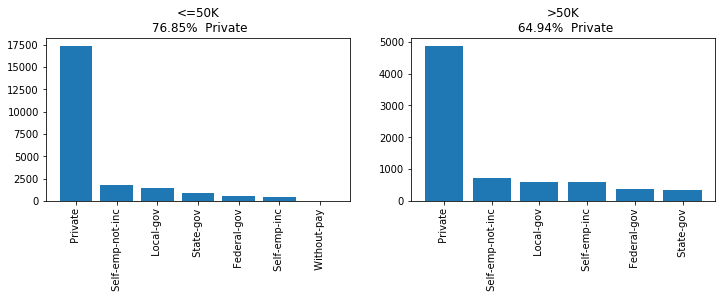

education


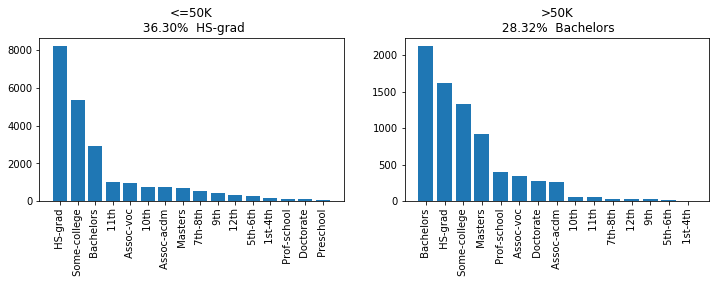

marital-status


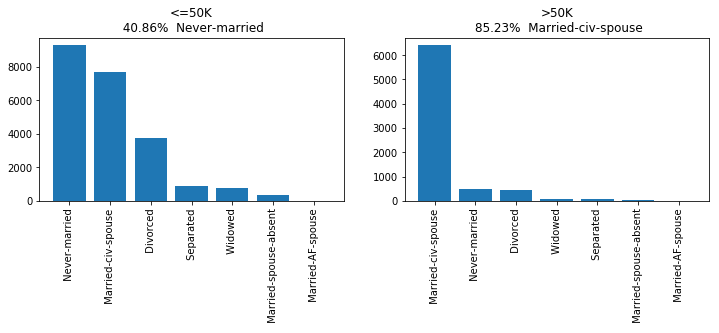

occupation


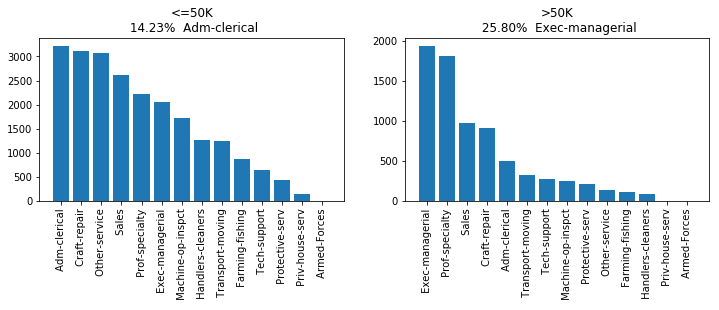

relationship


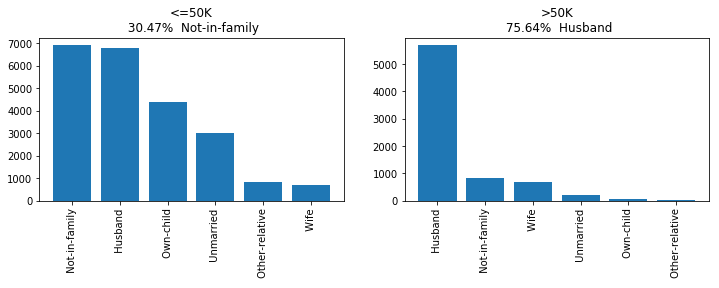

race


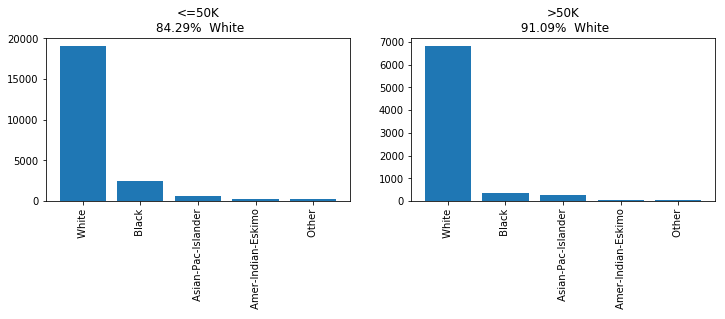

sex


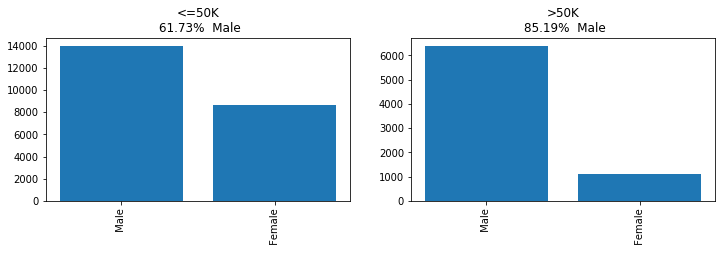

native-country


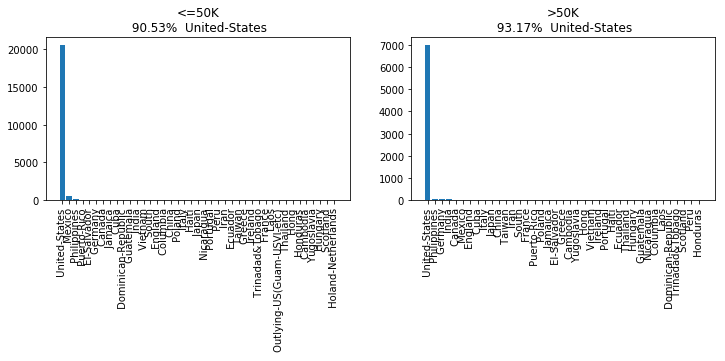

In [15]:
big_list = []

titles = ['<=50K', '>50K']

for n in range(len(df_cat.columns)):

    small_list = [df_cat.columns[n]]

    plt.figure(figsize=(12, 3))
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        keys = list(
            dict(df_cat_targ.iloc[:, n][df_cat_targ.Target == i].value_counts()).keys())
        vals = list(
            dict(df_cat_targ.iloc[:, n][df_cat_targ.Target == i].value_counts()).values())

        inds = np.argsort(vals)
        sorted_keys = np.array(keys)[inds]

        plt.bar(sorted(keys), sorted(vals)[::-1])
        plt.xticks(np.arange(len(keys)),
                   sorted_keys[::-1], rotation='vertical')

        m = max(vals) / np.sum(vals) * 100  # proportion of max value
        v = keys[vals.index(max(vals))]  # most numerous variable

        plt.title(titles[i] + "\n {0:.2f}% ".format(m) + str(v))
        small_list.append("{0:.2f}% ".format(m) + str(v))

    big_list.append(small_list)

    t = df_cat_targ.columns[n]  # title/column
    print(t)
    print('=============')

    plt.show()

The top values per each feature are summarized in the table below. 

In [16]:
print("Most Frequent Feature Values")
print("=======================")
cols = ['Feature','<=50K', '>50K']
pd.DataFrame(big_list, columns=cols)

Most Frequent Feature Values


,Feature,<=50K,>50K
0,workclass,76.85% Private,64.94% Private
1,education,36.30% HS-grad,28.32% Bachelors
2,marital-status,40.86% Never-married,85.23% Married-civ-spouse
3,occupation,14.23% Adm-clerical,25.80% Exec-managerial
4,relationship,30.47% Not-in-family,75.64% Husband
5,race,84.29% White,91.09% White
6,sex,61.73% Male,85.19% Male
7,native-country,90.53% United-States,93.17% United-States


The histograms of numerical data from the two income classes. For the most part, the distributions of datapoints of the two classes overlap, except for `capital-gain` which clearly shows separation. The mean age of the two classes are much different as well. Those in the higher income class tend to be older than those in the lower income class.

age


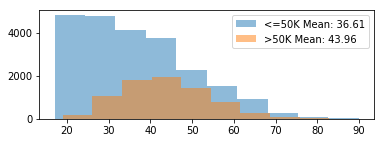

fnlwgt


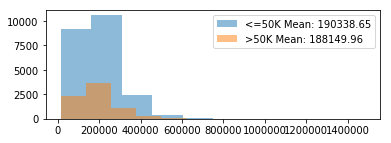

capital-gain


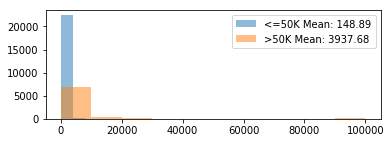

capital-loss


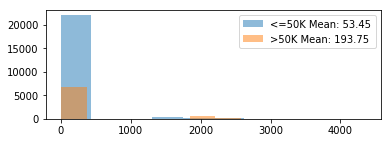

hours-per-week


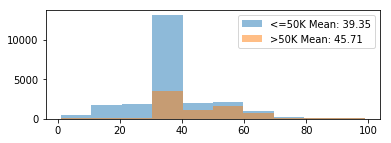

In [17]:
big_list2 = []

titles = ['<=50K', '>50K']

for n in range(len(df_num.columns)):

    small_list = [df_num.columns[n]]

    plt.figure(figsize=(6, 2))
    for i in range(2):
        plt.gca()
        vals = list(df_num_targ.iloc[:, n][df_num_targ.Target == i])
        
        m = np.mean(vals)  # mean value
        
        plt.hist(vals, alpha=0.5, label=titles[i]+" Mean: {0:.2f}".format((m)))
        plt.legend()
        
        small_list.append("{0:.2f}".format(m))

    big_list2.append(small_list)

    t = df_num_targ.columns[n]  # title/column
    print(t)
    print('=============')

    plt.show()

The table below summarizes the means per each feature and income class. Aside from the observations mentioned above, we see that those in >50k tend to have higher `capital-loss` and `hours-per-week`.

In [18]:
cols = ['Feature', '<=50K', '>50K']

print("Mean of Feature Values")
print("=======================")
pd.DataFrame(big_list2, columns=cols)

Mean of Feature Values


,Feature,<=50K,>50K
0,age,36.61,43.96
1,fnlwgt,190338.65,188149.96
2,capital-gain,148.89,3937.68
3,capital-loss,53.45,193.75
4,hours-per-week,39.35,45.71


## Models
#### Proportional Chance Criterion
The Proportional Chance Criterion (PCC) measures the chance of correctly classifying a datapoint based on chance alone. As a rule of thumb, to say that our model works, we need to exceed prediction accuracy of 1.25 x PCC. In this case, we need to exceed 78% accuracy.

Population per class:


,Counts
<=50K,22654
>50K,7508


1.25 * Proportion Chance Criterion: 78.26%


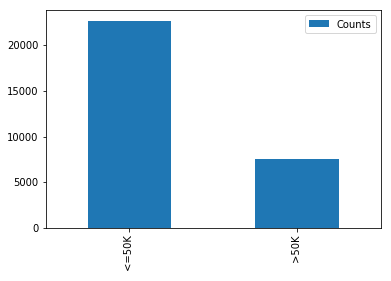

In [19]:
state_counts = Counter(y_temp)
df_state = pd.DataFrame.from_dict(state_counts, orient='index')
df_state.columns = ['Counts']
df_state.plot(kind='bar')
print("Population per class:")
display(df_state)
num = (df_state['Counts'] / df_state['Counts'].sum())**2
print(
    "1.25 * Proportion Chance Criterion: {0:.2f}%".format(1.25 * 100 * num.sum()))

### Classifiers

In this section, we define several machine learning classification functions, namely:

|No.|Type|Name|
|:-|:-|:-|:-|
|1|Similarity-based learning|kNN Classifier|
|2|Error-based learning|Linear Regression|
|3|Error-based learning|Logistic Regression|
|4|Error-based learning|Support Vector Machine Classifier|
|5|Information-based learning|Decision Tree Classifier|
|6|Information-based learning|Random Forest Classifier|
|7|Information-based learning|Gradient Boosting Classifier|
|8|Probability-based learning|Naive-Bayes Classifier|


In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

In [21]:
class ML_Classifier:

    def fit(self, feature, target, ml_type,
            param_range, seed_settings=range(0, 3)):
        """
        Fit data to machine learning regressor. Iterate regression model 
        mutiple times. Return the maximum accuracy achieved and the
        corresponding parameter.

        Inputs
        ======
        feature: Dataframe of features
        target: Series of target values
        param_range: Range of values for parameters
        seed_settings: Range of seed settings to run

        Outputs
        =======
        acc_max: Float. Maximum regression accuracy achieved.
        param_max: Float. Regressor parameter that gives maximum accuracy.
        """

        self.param_range = param_range
        self.ml_type = ml_type

        train_acc = []
        test_acc = []

        feature_importance = []

        # Initiate counter for number of trials
        self.iterations = 0

        # create an array of cols: parameters and rows: seeds
        for seed in seed_settings:

            # count one trial
            self.iterations += 1

            # split data into test and training sets
            X_train, X_test, y_train, y_test = train_test_split(feature,
                                                                target,
                                                                random_state=seed)
            train = []
            test = []
            coefs = []

            # make a list of accuracies for different parameters
            for param in param_range:
                # build the model
                if ml_type == 'knn_class':
                    clf = KNeighborsClassifier(n_neighbors=param)

                elif ml_type == 'log_reg':
                    clf = LogisticRegression(C=param, penalty=self.penalty)

                elif ml_type == 'linear_svm':
                    clf = LinearSVC(C=param, penalty=self.penalty, dual=False)

                elif ml_type == 'svm':
                    clf = SVC(C=param, kernel=self.kernel)

                elif ml_type == 'decision_tree':
                    clf = DecisionTreeClassifier(max_depth=param)

                elif ml_type == 'random_forest':
                    clf = RandomForestClassifier(
                        max_features=int(np.sqrt(X_train.shape[1])), max_depth=param)

                elif ml_type == 'gbm':
                    clf = GradientBoostingClassifier(max_depth=param)

                elif ml_type == 'naive_bayes':
                    clf = GaussianNB()

                # fit training set to classifier
                clf.fit(X_train, y_train)

                # record training set accuracy
                train.append(clf.score(X_train, y_train))

                # record generalization accuracy
                test.append(clf.score(X_test, y_test))

                # record coefficients if ml_type != knn_class
                # get coef @ 0.01
                if ml_type not in ("knn_class", "svm", "decision_tree", "gbm") and param == 0.01:
                    coefs.append(clf.coef_)

                if ml_type in ("decision_tree", "gbm"):
                    feature_importance.append(clf.feature_importances_)

            # append the list to _acc arrays
            train_acc.append(train)
            test_acc.append(test)

        # compute mean and error across columns
        self.train_all = np.mean(train_acc, axis=0)
        self.test_all = np.mean(test_acc, axis=0)

        # compute mean coefficients
        if ml_type not in ("knn_class", "svm", "decision_tree"):
            self.coefs_all = np.mean(coefs, axis=0).ravel()

        if ml_type in ("decision_tree", "gbm"):
            self.coefs_all = np.mean(feature_importance, axis=0)

        # compute variance of accuracies
        self.var_train = np.var(train_acc, axis=0)
        self.var_test = np.var(test_acc, axis=0)

        # compute the best parameter and maximum accuracy
        self.max_inds = np.argmax(self.test_all)
        self.acc_max = np.amax(self.test_all)
        self.param_max = (self.param_range)[self.max_inds]
        
        # compute 1.25 x pcc
        state_counts = Counter(target)
        df_state = pd.DataFrame.from_dict(state_counts, orient='index')
        num = (df_state[0] / df_state[0].sum())**2
        self.pcc = 1.25 * num.sum()

        return np.round(self.acc_max, 4), self.param_max

    def plot(self, report=True):
        """
        Plot accuracy vs parameter for test and training data. Print
        maximum accuracy and corresponding parameter value. Print number of 
        trials.

        Inputs
        ======
        report: Boolean. Will show report if True

        Outputs
        =======
        Plot of accuracy vs parameter for test and training data
        Report showing number of maximum accuracy, optimal parameters
        and no. of iterations
        """

        if self.ml_type in ["log_reg", "linear_svm", "svm"]:
            plt.xscale("log")

        # plot train and errors and standard devs
        plt.plot(self.param_range, self.train_all, c='b',
                 label="training set", marker='.')
        plt.fill_between(self.param_range,
                         self.train_all + self.var_train,
                         self.train_all - self.var_train,
                         color='b', alpha=0.1)

        # plot test and errors and standard devs
        plt.plot(self.param_range, self.test_all,
                 c='r', label="test set", marker='.')
        plt.fill_between(self.param_range,
                         self.test_all + self.var_test,
                         self.test_all - self.var_test,
                         color='r', alpha=0.1)

        plt.xlabel('Parameter Value')
        plt.ylabel('Accuracy')
        plt.title(self.ml_type + ": Accuracy vs Parameter Value")

        plt.plot(self.param_range, [self.pcc] * len(self.param_range),
                 c='tab:gray', label="1.25 x PCC", linestyle='--')

        plt.legend(loc=0)
        plt.tight_layout()
        plt.show()

        if report == True:
            print('Report:')
            print('=======')
            print("Max average accuracy: {}".format(
                np.round(self.acc_max, 4)))
            print("Var of accuracy at optimal parameter: {0:.4f}".format(
                self.var_test[self.max_inds]))
            print("Optimal parameter: {0:.4f}".format(self.param_max))
            if self.ml_type in ['log_reg', 'linear_svm']:
                print("Regularization: ", self.penalty)
            print('Total iterations: {}'.format(self.iterations))
            print('1.25 x PCC: {0:.4f}'.format(self.pcc))
            print('Total iterations: {}'.format(self.iterations))

#### kNN Classifier

kNN is an algorithm that we can use to classify a new observation based on the classifications of historical observations. Loosely speaking, new observations are classified based on how closely they resemble the features of historical observations. 

The important parameter of kNN is k , which refers to the number of nearest neighbors or number of training datapoints with features closest to the features of the new datapoint being classified. The more nearest neighbors considered (larger k), the more the model considers the training data in general. The fewer nearest neighbors considered (smaller k), the more the model considers individual datapoints. Too high k and the model risks underfitting. Too low k and the model risks overfitting.

The chart below shows the accuracy vs parameter value (nearest neighbors, k) on the training set (blue line) and test set (red line). The red and blue lines show the average accuracies from 3 iterations (different sampling of training and testing set from the original dataset). The proportional chance criterion is plotted as a dashed horizontal gray line. The transparent colored areas around the lines show the extent of one standard deviation from the average.

We are interested in the model's performance or accuracy on the test set (red line). We observe that running all features on kNN gives a classification accuracy of only 78% using an optimal parameter of 8 nearest neighbors, only teasing ever slightly above the PCC.

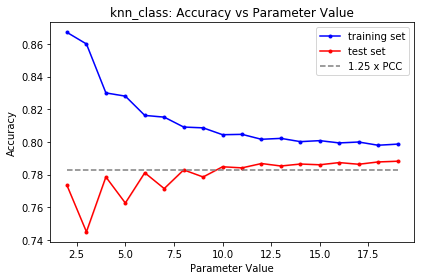

Report:
Max average accuracy: 0.7882
Var of accuracy at optimal parameter: 0.0000
Optimal parameter: 19.0000
Total iterations: 3
1.25 x PCC: 0.7826
Total iterations: 3

Confusion Matrix Using Best Parameters


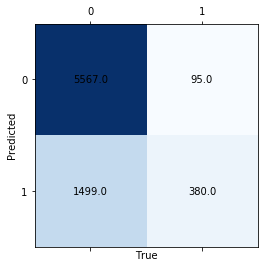

In [22]:
# we used the default number of iterations = 3
# check ml_class

from collections import Counter

ml_class = ML_Classifier()
param_range = range(2, 20)
acc_knn_class, param_knn_class = ml_class.fit(
    X, y, ml_type='knn_class', param_range=param_range)
ml_class.plot()

# predicting
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
knc = KNeighborsClassifier(n_neighbors=param_knn_class)
knc.fit(X_train, y_train)
y_pred = knc.predict(X_test)

param_knn_class = {'n neighbors' : param_knn_class}

# Confusion Matrix
print()
print("Confusion Matrix Using Best Parameters")
cm = confusion_matrix(y_test, y_pred)
plt.matshow(cm, cmap=plt.cm.Blues)
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

#### Logistic Regression L1

Logistic Regression is another classification algorithm (even though it's called regression) derived from linear regression, but instead of calculating a continuous outcome, it calculates the most probable categorical outcome. To illustrate this, say we want to predict the score of an athlete in a competition, given the hours of practicing, then linear regression may be used. But if we want to calculate the odds that the athlete will win the competition, then we can use logistic regression.

The important parameter of logistic regression, C, can be looked at as like a "regularization" or "generalization" factor. The higher the value of C, the more the classifier give weight to individual datapoints, while the lower its value, the more the classifier gives weight to the training dataset as a whole. C with too high a value results in overfitting the training data, which reduces generalizability on new datapoints. While C with too low a value results in underfitting, and results in too low accuracies on either the training data or test data.

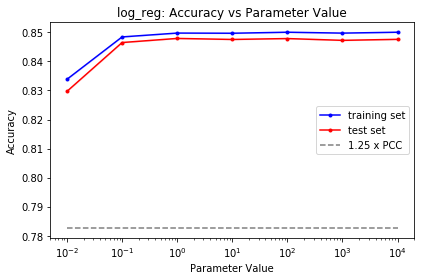

Report:
Max average accuracy: 0.8479
Var of accuracy at optimal parameter: 0.0000
Optimal parameter: 1.0000
Regularization:  l1
Total iterations: 3
1.25 x PCC: 0.7826
Total iterations: 3

Confusion Matrix Using Best Parameters


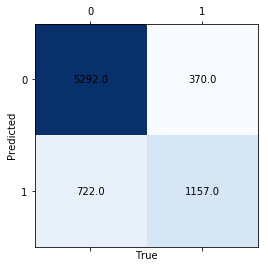

In [23]:
ml_class = ML_Classifier()
penalty = 'l1'
ml_class.penalty = penalty
param_range = [0.01, 0.1, 1, 10, 100, 1000, 10000]
acc_log_reg_l1, param_log_reg_l1 = ml_class.fit(
    X, y, ml_type='log_reg', param_range=param_range)
ml_class.plot()

# predicting
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
clf = LogisticRegression(penalty=penalty, C=param_log_reg_l1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
inds = np.argsort(clf.coef_[0])[::-1]  # n classes X n features

top_predictor_log_reg_l1 = X.columns[inds]

param_log_reg_l1 = {'C' : param_log_reg_l1}

# Confusion Matrix
print()
print("Confusion Matrix Using Best Parameters")
cm = confusion_matrix(y_test, y_pred)
plt.matshow(cm, cmap=plt.cm.Blues)
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()



#### Logistic Regression L2

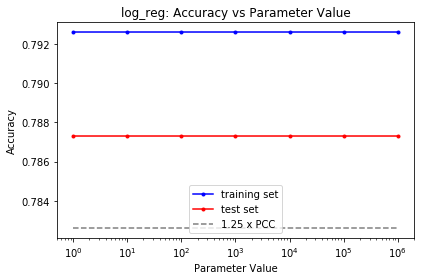

Report:
Max average accuracy: 0.7873
Var of accuracy at optimal parameter: 0.0000
Optimal parameter: 1.0000
Regularization:  l2
Total iterations: 3
1.25 x PCC: 0.7826
Total iterations: 3

Confusion Matrix Using Best Parameters


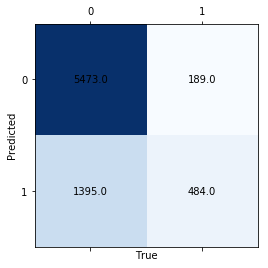

In [24]:
ml_class = ML_Classifier()
penalty = 'l2'
ml_class.penalty = penalty
param_range = [1, 10, 100, 1000, 10000, 100000, 1000000]
acc_log_reg_l2, param_log_reg_l2 = ml_class.fit(
    X, y, ml_type='log_reg', param_range=param_range)
ml_class.plot()

# predicting
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
clf = LogisticRegression(penalty=penalty, C=param_log_reg_l2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
inds = np.argsort(clf.coef_[0])[::-1]  # n classes X n features

top_predictor_log_reg_l2 = X.columns[inds]
    
param_log_reg_l2 = {'C' : param_log_reg_l2}

# Confusion Matrix
print()
print("Confusion Matrix Using Best Parameters")
cm = confusion_matrix(y_test, y_pred)
plt.matshow(cm, cmap=plt.cm.Blues)
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

# ROC Curve
# roc_curve(y_test, y_pred)

#### Linear SVM L1

#### Linear SVC
Linear Support Vector Classifier (SVC) is another classification algorithm that works by finding the lines, planes, or hyperplanes (in the case beyond three features or dimensions) that divide the observations into two or more classes. In this case, the classes are whether or not the person earns more than 50,000 USD annually. The important parameter C for Linear SVC works like in logistic regression. 

Similarly with logistic regression, the feature coefficients in SVC can be thought of as the weights on each feature. The larger the weight, the more influential that feature is on the classification. The chart below shows the coefficient values vs the index of the feature for SVC using optimal C determined above. Notice that some of the coefficients have become 0.

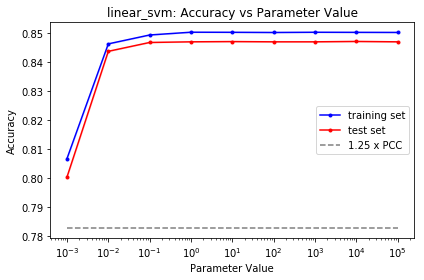

Report:
Max average accuracy: 0.847
Var of accuracy at optimal parameter: 0.0000
Optimal parameter: 10000.0000
Regularization:  l1
Total iterations: 3
1.25 x PCC: 0.7826
Total iterations: 3

Confusion Matrix Using Best Parameters


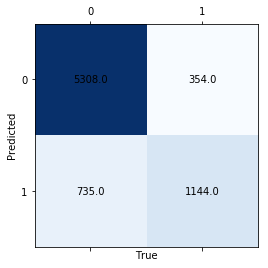

In [25]:
ml_class = ML_Classifier()
penalty = 'l1'
ml_class.penalty = penalty
param_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
acc_lsvm_l1, param_lsvm_l1 = ml_class.fit(
    X, y, ml_type='linear_svm', param_range=param_range)
ml_class.plot()

# predicting
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
clf = LinearSVC(penalty=penalty, C=param_lsvm_l1, dual=False)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
inds = np.argsort(clf.coef_[0])[::-1]  # n classes X n features

top_predictor_lsvm_l1 = X.columns[inds]

param_lsvm_l1 = {'C' : param_lsvm_l1}

# Confusion Matrix
print()
print("Confusion Matrix Using Best Parameters")
cm = confusion_matrix(y_test, y_pred)
plt.matshow(cm, cmap=plt.cm.Blues)
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

# ROC Curve
# roc_curve(y_test, y_pred)

#### Linear SVM L2

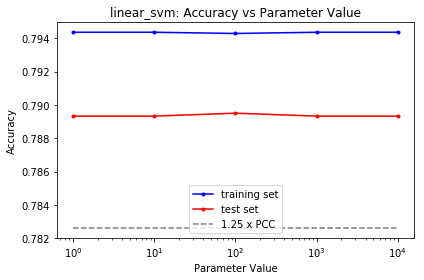

Report:
Max average accuracy: 0.7895
Var of accuracy at optimal parameter: 0.0000
Optimal parameter: 100.0000
Regularization:  l2
Total iterations: 3
1.25 x PCC: 0.7826
Total iterations: 3

Confusion Matrix Using Best Parameters


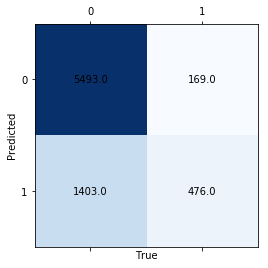

In [26]:
ml_class = ML_Classifier()
penalty = 'l2'
ml_class.penalty = penalty
param_range = [1, 10, 100, 1000, 10000]
acc_lsvm_l2, param_lsvm_l2 = ml_class.fit(
    X, y, ml_type='linear_svm', param_range=param_range)
ml_class.plot()

# predicting
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
clf = LinearSVC(penalty=penalty, C=param_lsvm_l2, dual=False)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
inds = np.argsort(clf.coef_[0])[::-1]  # n classes X n features

top_predictor_lsvm_l2 =  X.columns[inds]

param_lsvm_l2 = {'C' : param_lsvm_l2}

# Confusion Matrix
print()
print("Confusion Matrix Using Best Parameters")
cm = confusion_matrix(y_test, y_pred)
plt.matshow(cm, cmap=plt.cm.Blues)
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

# ROC Curve
# roc_curve(y_test, y_pred)

#### Decision Tree

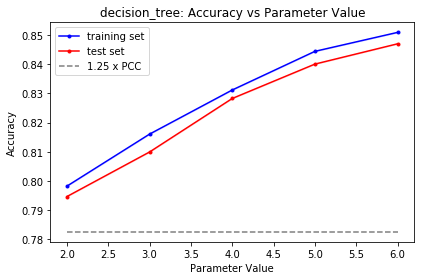

Report:
Max average accuracy: 0.8469
Var of accuracy at optimal parameter: 0.0000
Optimal parameter: 6.0000
Total iterations: 3
1.25 x PCC: 0.7826
Total iterations: 3

Confusion Matrix Using Best Parameters


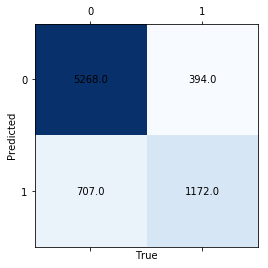

In [27]:
ml_class = ML_Classifier()
param_range = [2, 3, 4, 5, 6]
acc_dt, param_dt = ml_class.fit(
    X, y, ml_type='decision_tree', param_range=param_range)
ml_class.plot()

# predicting
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
clf = DecisionTreeClassifier(max_depth=param_dt)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
inds = np.argsort(ml_class.coefs_all)[::-1]  # n classes X n features
top_predictor_dt = X.columns[inds]
    
param_dt = {'max_depth' : param_dt}

# Confusion Matrix
print()
print("Confusion Matrix Using Best Parameters")
cm = confusion_matrix(y_test, y_pred)
plt.matshow(cm, cmap=plt.cm.Blues)
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

# ROC Curve
# roc_curve(y_test, y_pred)

#### Random Forest

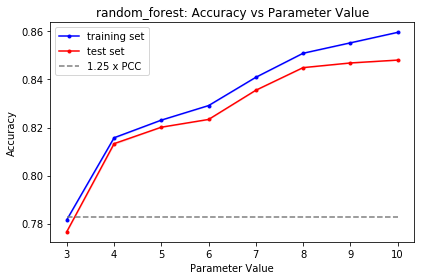

Report:
Max average accuracy: 0.8481
Var of accuracy at optimal parameter: 0.0000
Optimal parameter: 10.0000
Total iterations: 3
1.25 x PCC: 0.7826
Total iterations: 3

Confusion Matrix Using Best Parameters


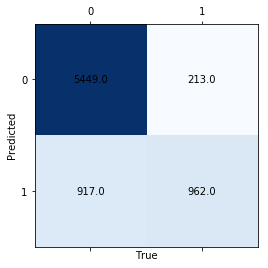

In [28]:
ml_class = ML_Classifier()
param_range = [3, 4, 5, 6, 7, 8, 9, 10]
acc_rf, param_rf = ml_class.fit(
    X, y, ml_type='random_forest', param_range=param_range)
ml_class.plot()

# predicting
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
clf = RandomForestClassifier(max_depth=param_rf)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
inds = np.argsort(clf.feature_importances_)[::-1]  # n classes X n features
top_predictor_rf = X.columns[inds]
    
param_rf = {'max_depth' : param_rf}

# Confusion Matrix
print()
print("Confusion Matrix Using Best Parameters")
cm = confusion_matrix(y_test, y_pred)
plt.matshow(cm, cmap=plt.cm.Blues)
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

# ROC Curve
# roc_curve(y_test, y_pred)

#### Gradient Boosting

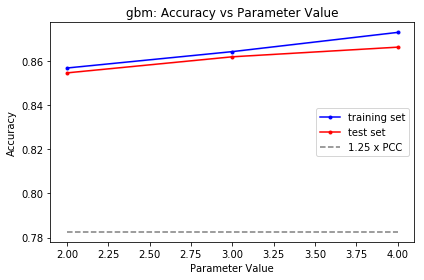

Report:
Max average accuracy: 0.8664
Var of accuracy at optimal parameter: 0.0000
Optimal parameter: 4.0000
Total iterations: 3
1.25 x PCC: 0.7826
Total iterations: 3

Confusion Matrix Using Best Parameters


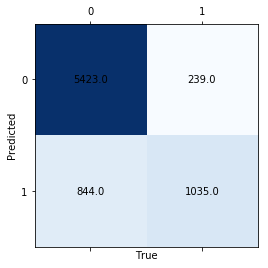

In [29]:
ml_class = ML_Classifier()
param_range = [2, 3, 4]
acc_gbm_class, param_gbm_class = ml_class.fit(
    X, y, ml_type='gbm', param_range=param_range)
ml_class.plot()

# predicting
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
clf = GradientBoostingClassifier(max_features=param_gbm_class)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
inds = np.argsort(ml_class.coefs_all)[::-1]  # n classes X n features

top_predictor_gbm = X.columns[inds]

param_gbm_class = {'max_depth' : param_gbm_class}

# Confusion Matrix
print()
print("Confusion Matrix Using Best Parameters")
cm = confusion_matrix(y_test, y_pred)
plt.matshow(cm, cmap=plt.cm.Blues)
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

# ROC Curve
# roc_curve(y_test, y_pred)

#### Naive Bayes

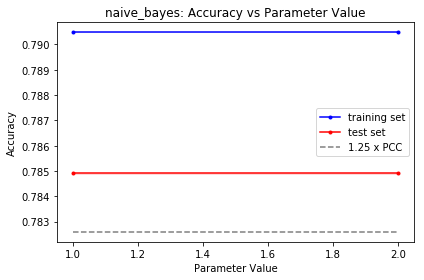

Report:
Max average accuracy: 0.7849
Var of accuracy at optimal parameter: 0.0000
Optimal parameter: 1.0000
Total iterations: 3
1.25 x PCC: 0.7826
Total iterations: 3

Confusion Matrix Using Best Parameters


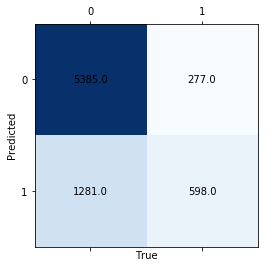

In [30]:
ml_class = ML_Classifier()
acc_naive_bayes, param_naive_bayes = ml_class.fit(
    X, y, ml_type='naive_bayes', param_range=(1, 2))
ml_class.plot()

# predicting
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
inds = np.argsort(ml_class.coefs_all)[::-1]  # n classes X n features

top_predictor_naive_bayes = X.columns[inds]

param_naive_bayes = '-'

# Confusion Matrix
print()
print("Confusion Matrix Using Best Parameters")
cm = confusion_matrix(y_test, y_pred)
plt.matshow(cm, cmap=plt.cm.Blues)
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

# ROC Curve
# roc_curve(y_test, y_pred)

### Summary

In [31]:
classifiers = pd.Series(['knn_class',
                         'log_reg_l1',
                         'log_reg_l2',
                         'linear_svm_l1',
                         'linear_svm_l2',
                         'decision_tree',
                         'random_forest',
                         'gbm',
                         'naive_bayes'], name='ML_Type')

accuracies = pd.Series([acc_knn_class,
                        acc_log_reg_l1,
                        acc_log_reg_l2,
                        acc_lsvm_l1,
                        acc_lsvm_l2,
                        acc_dt,
                        acc_rf,
                        acc_gbm_class,
                        acc_naive_bayes], name='Accuracy')

parameters = pd.Series([param_knn_class, 
                        param_log_reg_l1, 
                        param_log_reg_l2,
                        param_lsvm_l1,
                        param_log_reg_l2,
                        param_dt,
                        param_rf, 
                        param_gbm_class,
                       param_naive_bayes], name='Best Parameter')

top_predictors = pd.Series(['-', 
                            top_predictor_log_reg_l1[:3].values,
                            top_predictor_log_reg_l2[:3].values,
                            top_predictor_lsvm_l1[:3].values,
                            top_predictor_lsvm_l2[:3].values,
                            top_predictor_dt[:3].values,
                            top_predictor_rf[:3].values, 
                            top_predictor_gbm[:3].values,
                           '-'], name="Top Predictor")
df_summary = pd.concat(
    [classifiers, accuracies, parameters, top_predictors], axis=1)
df_summary_sorted = df_summary.sort_values(by="Accuracy", ascending=False)
df_summary_sorted

,ML_Type,Accuracy,Best Parameter,Top Predictor
7,gbm,0.8664,{'max_depth': 4},"[marital-status_ Married-civ-spouse, capital-g..."
6,random_forest,0.8481,{'max_depth': 10},"[capital-gain, relationship_ Husband, marital-..."
1,log_reg_l1,0.8479,{'C': 1},"[education_ Doctorate, education_ Prof-school,..."
3,linear_svm_l1,0.8470,{'C': 10000},"[native-country_ Yugoslavia, education_ Doctor..."
5,decision_tree,0.8469,{'max_depth': 6},"[marital-status_ Married-civ-spouse, capital-g..."
4,linear_svm_l2,0.7895,{'C': 1},"[marital-status_ Married-civ-spouse, relations..."
0,knn_class,0.7882,{'n neighbors': 19},-
2,log_reg_l2,0.7873,{'C': 1},"[marital-status_ Married-civ-spouse, relations..."
8,naive_bayes,0.7849,-,-


In [32]:
pd.set_option('display.max_colwidth', -1)
df_summary_sorted[['ML_Type', 'Accuracy', 'Top Predictor']]

,ML_Type,Accuracy,Top Predictor
7,gbm,0.8664,"[marital-status_ Married-civ-spouse, capital-gain, capital-loss]"
6,random_forest,0.8481,"[capital-gain, relationship_ Husband, marital-status_ Never-married]"
1,log_reg_l1,0.8479,"[education_ Doctorate, education_ Prof-school, education_ Masters]"
3,linear_svm_l1,0.8470,"[native-country_ Yugoslavia, education_ Doctorate, education_ Prof-school]"
5,decision_tree,0.8469,"[marital-status_ Married-civ-spouse, capital-gain, capital-loss]"
4,linear_svm_l2,0.7895,"[marital-status_ Married-civ-spouse, relationship_ Husband, occupation_ Exec-managerial]"
0,knn_class,0.7882,-
2,log_reg_l2,0.7873,"[marital-status_ Married-civ-spouse, relationship_ Husband, capital-loss]"
8,naive_bayes,0.7849,-


## Results
Using all 103 features we tested various classifiers namely: GBM, random forest, decision tree, logistic regression, SVM, kNN, and naive bayes classifier.

With the minimum target accuracy of 78%, the top three models that give the highest classification accuracy are GBM (86.6%), random forest (84.8%), and logistic regression with L1 normalization (84.8%). The top predictor shared by these three classifiers is marital status.

Note that because more than 90% of the observations are from the US, the results may not be generalizeable for other populations.


## References and Acknowledgements
I would like to acknowledge Professor Christopher P. Monterola whose Python codes were the foundation of some of the codes used for this analysis.
<br>Dataset was downloaded from: https://archive.ics.uci.edu/ml/datasets/census+income